## Final Project: House Prices Prediction
https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

### Team MLAIRE: Chi Iong Ansjory, Prabhat Tripathi, Soodong Kim, Tina Agarwal

## Problem

The goal of this project is to predict sale price of residential homes in Ames, Iowa based on the given training and test data sets. There are 79 explanatory variables describing different aspects of residential homes with 1460 observations in both training and test data sets (this is different than previous class projects where train data is usually larger than test data set). 

The output variable (SalePrice) is quantitative (continuous) whereas the explanatory (LHS) variables are a combination of quantitative (continuous) and categorical variables. 

Considering the size and nature of the data set, and informed by our domain understanding, we beleive that *feature engineering* -- crafting data features optimized for machine learning -- is key for better modeling for this problem. Specifically, we plan to perform following:

- Univariate analysis of output and explanatory variables: weed out spurious or wrong values. Understand patterns and outliers for each variable. Allow for missing values (NaN) imputations.
- Transform categorical variables into numeric (using dummy variables?)
- Check if log transformation of output and explanatory variables helps better model performance
- Identify and remove unhelpful explanatory variables (using correlation matrix or using techniques such as LASSO)
- Identify and remove multicollinearity, if present
- Advance feature engineering techniques such as PCA?

We also have to watch out for overfitting considering there are a large number of input variables (compared to the training data size).

We plan to begin with (multiple) LinearRegression model (for speed) and if the accuracy is not satisfactory, we would try other models such as random forest and gradient-boosting tree. If needed, we may have to ensemble all these models for better overall accuracy. We will split test data into two random sets and use one as "dev" data during model buidling process.

## Libraries Loading

In [169]:
# Each plot will not open a new window. 
%matplotlib inline

# Import relevant libraries.

# General libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy.stats import norm


# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for modeling
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.preprocessing import Imputer

# Libraries for files
import os

# Python fundamental libraries
import collections

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')


### Import Data

In [112]:
# Load Data

# Please keep this relative path access to data.
dir_name = os.getcwd()
train_filename = os.path.join(dir_name, 'data/train.csv')
test_filename = os.path.join(dir_name, 'data/test.csv')

# Reading the data
train = pd.read_csv(train_filename)
test  = pd.read_csv(test_filename)

# Look at the train data
train.info()

# Look at the test data
test.info()

print("\nThe train data shape is: {} ".format(train.shape)) 
print("\nThe test data shape is: {} ".format(test.shape))

train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Define Own Libraries

In [113]:
# Define helper functions
def get_distinct_num(values):
    return len(set(values))

def print_distinct_num(data, col_name):
    if col_name in data.keys():
        print("Distinct variation of {} is {}".format(col_name, get_distinct_num(data[col_name])))
    
def drop_column_if_existing(data, col_name):
    """
    Drops a column only if col_name exists. By having this method, each code chunk can be
    executed without loading data again.
    """
    if col_name in data.keys():
        train.drop([col_name], axis=1)

    return data

## Explanatory Data Analysis

### Feature Correlation

Top 10 correlation columns
MSSubClass  MSSubClass      1.000000
            LotFrontage     0.386347
            LotArea         0.139781
            OverallQual     0.032628
            OverallCond     0.059316
            YearBuilt       0.027850
            YearRemodAdd    0.040581
            MasVnrArea      0.022936
            BsmtFinSF1      0.069836
            BsmtFinSF2      0.065649
dtype: float64


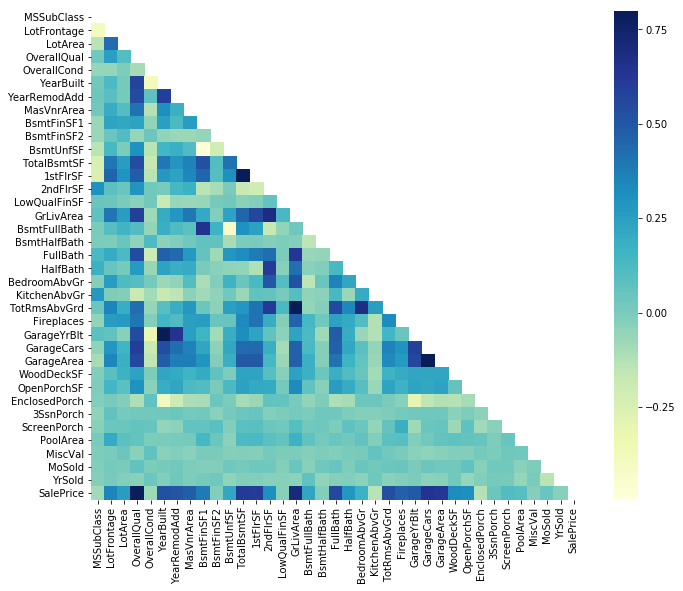

In [114]:
copied_train = train.copy()
copied_train = copied_train.drop(['Id'],axis=1,errors='raise') # Remove Id that is not relevant for corr analysis.
corr_matrix = copied_train.corr()
mask = np.zeros_like(corr_matrix) # Zero array with same shape of corr_matrix
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=0.8, square=True, cmap="YlGnBu", mask=mask)

corrs = corr_matrix.abs().unstack()
corrs.sort_values(kind="quicksort",ascending=False)
print("Top 10 correlation columns")
print(corrs[:10])

### Univariate Analysis

Based on the correlation heatmap above, a few highly correlated variables are picked for further univariate analysis. Plotting histograms for various variables to see if it is normally distributed and if logarithmic transformation is needed as well. Same exercise will be performed on more variables.

Text(0,0.5,'Frequency')

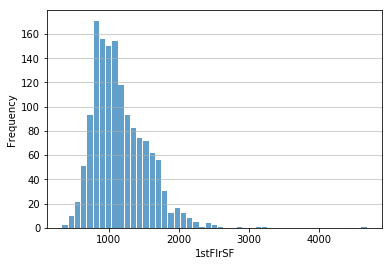

In [115]:
plt.hist(x=train['1stFlrSF'], bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('1stFlrSF')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

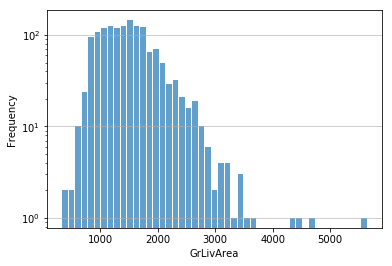

In [116]:
plt.hist(x=train['GrLivArea'], bins='auto', log=True, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('GrLivArea')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

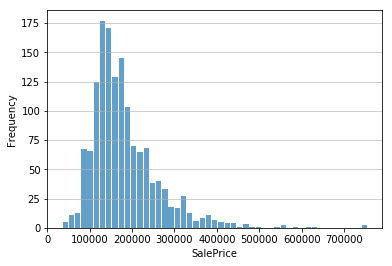

In [117]:
plt.hist(x=train['SalePrice'], bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

### Bivariate Analysis

In this section we will analyse relationship between output variable (SalePrice) and dependent variables to discriminate important predictor variables from spurious relationships. There are observable and potentially consistent outliers in both scatterplots below that we may need to perform further analysis on. Same exercise will be performed on more pairs of variables.

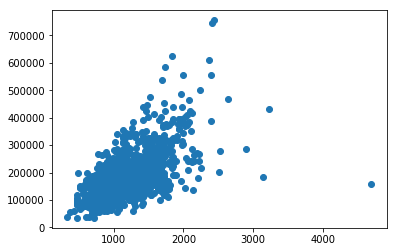

In [118]:
plt.scatter(x=train['1stFlrSF'], y=train['SalePrice'])

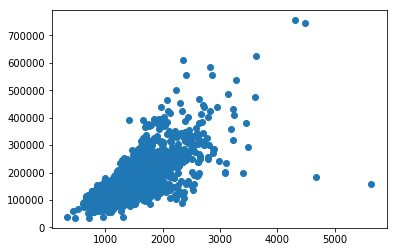

In [119]:
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'])

### Missing Data Analysis

In [120]:
# Investigate about missing data
# Analyze top 15 columns having missing data

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat(
    [total, percent], axis=1, keys=["Total Number of Missing Data", "Missing Data Percentage"])
missing_data.head(30)

,Total Number of Missing Data,Missing Data Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


There are 4 fields whose missing data portion is larger than 50%. Missing data will be cleaned up in the follow-up section.

### Exploring Target Variable Sales Price


In [121]:
#Exploring Target Variable Sales Price
copied_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5,1,'SalePrice')

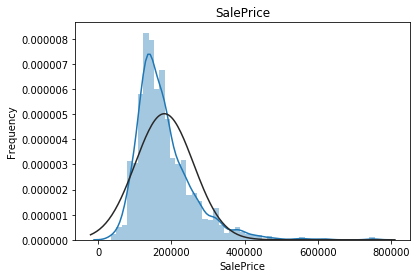

In [122]:
sns.distplot(train['SalePrice'],fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice')

Text(0.5,1,'Log_SalePrice')

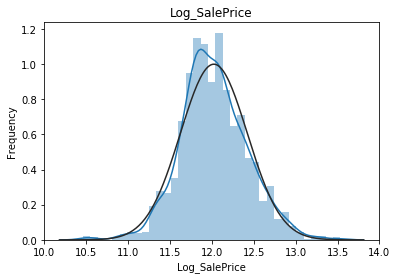

In [123]:
# Sale Price is right skewed so lets take log transformation
copied_train['Log_SalePrice']= np.log(copied_train['SalePrice'])
sns.distplot(copied_train['Log_SalePrice'],fit=norm);
plt.ylabel('Frequency')
plt.title('Log_SalePrice')

In [163]:
#train_imp = Imputer(train)
#test_imp= Imputer(test)
#miss_data = pd.concat([train_imp.missing_values.sum(),test_imp.missing_values.sum()], axis=1,keys =['Train','Test'])
#miss_data[miss_data.sum(axis=1) > 0]

In [164]:
# MSSubClass is categorical but it is encoded as numeric, convert the dtype object.
copied_train['MSSubClass'] = copied_train['MSSubClass'].astype('object')

### Find Numerical Data

In [125]:
#Numerical Data
train_num = copied_train.describe(include=[np.number])
print(train_num.shape)
train_num

(8, 37)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Log_SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,12.024051
std,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,0.399452
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,10.460242
25%,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,11.775097
50%,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,12.001505
75%,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,12.273731
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,13.534473


There are 36 relevant numerical features excluding saleprice and log saleprice

### Categorical Data

In [126]:
#Categorical Data
train_cat = copied_train.describe(include=[np.object])
print(train_cat.shape)
train_cat

(4, 44)


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,15,5,2,2,4,4,2,5,3,25,...,6,3,5,5,3,3,4,4,9,6
top,20,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,536,1151,1454,50,925,1311,1459,1052,1382,225,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [127]:
#check for Missing Data
copied_train.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageType         81
GarageQual         81
GarageCond         81
GarageFinish       81
BsmtFinType2       38
BsmtExposure       38
BsmtCond           37
BsmtFinType1       37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
RoofStyle           0
RoofMatl            0
ExterQual           0
Exterior1st         0
Exterior2nd         0
YearBuilt           0
ExterCond           0
Foundation          0
YearRemodAdd        0
Log_SalePrice       0
OverallCond         0
                 ... 
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
ScreenPorch         0
Functional          0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
Fireplaces          0
TotRmsAbvGrd        0
BsmtUnfSF           0
LowQualFin

In [128]:
traincopy_nan_columns = []

for column in copied_train:
    if copied_train[column].isnull().sum() > 0:
        traincopy_nan_columns.append(column)

traincopy_nan_columns

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

LotFrontage: Linear feet of street connected to property - replace with 0  
Alley: NA means 'no alley access'  
MasVnrType: None means no veneer  
MasVnrArea: Masonry Veneer area in square feet (na rows are the same as MasVnrType)  
BsmntQual: NA means 'no basement'  
BsmntCond: NA means 'no basement'  
BsmntExposure: NA means 'no basement'  
BsmntFinType1: NA means 'no basement'  
BsmntFinType2: NA means 'no basement'  
Electrical: will drop this value  
FireplaceQC: NA means 'no fireplace'  
GarageType: NA means 'no garage'  
GarageYrBlt: Replace with median  
GarageFinish: NA means 'no garage'  
GarageQual: NA means 'no garage'  
GarageCond: NA means 'no garage'  
PoolQC: NA means 'no pool'  
Fence: NA means 'no fence'  
MiscFeature: NA means 'None' (aka no miscellaneous features)  
For Masonry Veneer area, replace nulls with 0s  

For GarageYrBlt and LotFrontage, replace with median.  

For LotFrontage and Veneer, will use 0. #lotfrontgae and garageyrbuild = median, masvnr area - 0  

In [129]:
copied_train['LotFrontage'] = copied_train['LotFrontage'].fillna(0)

copied_train['Alley'] = copied_train['Alley'].fillna('no_alley')

copied_train['MasVnrType'] = copied_train['MasVnrType'].fillna('no_veneer')

copied_train['MasVnrArea'] = copied_train['MasVnrArea'].fillna(0)

copied_train['BsmtQual'] = copied_train['BsmtQual'].fillna('no_basement')

copied_train['BsmtCond'] = copied_train['BsmtCond'].fillna('no_basement')

copied_train['BsmtExposure'] = copied_train['BsmtExposure'].fillna('no_basement')

copied_train['BsmtFinType1'] = copied_train['BsmtFinType1'].fillna('no_basement')

copied_train['BsmtFinType2'] = copied_train['BsmtFinType2'].fillna('no_basement')

copied_train['Electrical'] = copied_train['Electrical'].fillna('no_electricity')

copied_train['FireplaceQu'] = copied_train['FireplaceQu'].fillna('no_fireplace')

copied_train['GarageType'] = copied_train['GarageType'].fillna('no_garage')

copied_train['GarageYrBlt'] = copied_train['GarageYrBlt'].fillna(np.nanmedian(copied_train['GarageYrBlt']))

copied_train['GarageFinish'] = copied_train['GarageFinish'].fillna('no_garage')

copied_train['GarageQual'] = copied_train['GarageQual'].fillna('no_garage')

copied_train['GarageCond'] = copied_train['GarageCond'].fillna('no_garage')

copied_train['PoolQC'] = copied_train['PoolQC'].fillna('no_pool')

copied_train['Fence'] = copied_train['Fence'].fillna('no_fence')

copied_train['MiscFeature'] = copied_train['MiscFeature'].fillna('no_misc_features')

In [130]:
#Verify there are no null values
copied_train.isnull().sum().sum()

0

### Convert categorical features to numeric features. Verify there are no null values before doing this

In [133]:
#define categorical columns list
copied_train_dummies = pd.get_dummies(copied_train)
copied_train_dummies.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,1,0,0,0,0,1,0


In [134]:
copied_train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 320 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(4), int64(33), uint8(283)
memory usage: 825.6 KB


### Split the data into train and test set

In [157]:
X= copied_train_dummies.drop('SalePrice',axis=1)
X= copied_train_dummies.drop('SalePrice',axis=1)

In [158]:
y = copied_train_dummies['SalePrice']

In [144]:
#X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.5)

### Scale the Data

In [145]:
stdscaler = StandardScaler()
X_train_scaled = stdscaler.fit_transform(X_train)
X_test_scaled = stdscaler.transform(X_test)

In [ ]:
#X = copied_train.iloc[:,0:-1].values
#Y = copied_train.iloc[:,-1].values
#print(X)
#print(Y)

## Modeling

In this section, we plan to perform:
* Feature Engineering
* Dimentionality reduction
* Building and tuning home prices prediction models


From 79 available features (input variables), we will find statistically and practically significant variables for modeling. We also will try to watch out for collinearity and spurious relationships.  

We plan to start with LinearRegression model because of the predictive nature of the problem. We will also try other supervised learning models such as Random Forest and Gradient Boosting Tree if they increase accuracy.

We will be working on two broad sets of algorithms:
1. Linear Models
2. Non Linear relationships using Random Forests

#### Linear Models
For linear models, we will try and test with the regular OLS model, and the regularized linear models of Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), and Elastic Net. 

For model tuning, Sklearn's grid search with CV function will be used to find the optimal hyper-parameter values.

To assess the predictive performance of regression models, we can compute the mean sum of squared errors and the related summary metric. Furthermore, we can also use graphical approach of residual plots to diagnose problems of linear regression models

We can apply regularization to our regression models to reduce the model complexity and avoid overfitting.

#### Non Linear relationships using Random Forests
For the decision tree algorithm, we will subdivide the input space into smaller regions so that it's more manageable. As Decision tree algorithm does not require any transformation of the features for nonlinear data, there will not be any feature transformation in this section. Since random forests are less sensitive to outliers in the dataset we are assuming at this point that it will not require much parameter tuning. The only parameter that will require experimenting might be number of trees. 

In [159]:
## Split the data for simple linear regression
lr_train_data, lr_train_labels = X[:1100], Y[:1100]
lr_dev_data, lr_dev_labels = X[1100:], Y[1100:]

In [160]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

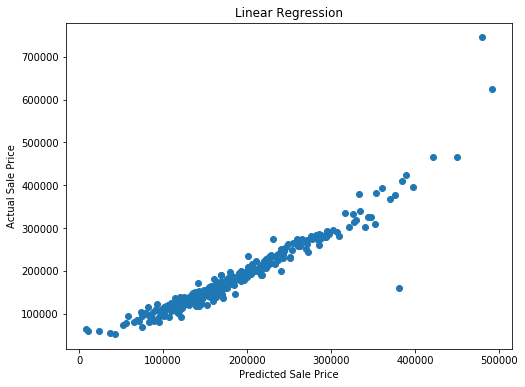

Mean accuracy...11580.340404796461 	RMSE...23857.351805645085 	Regression score... 0.9087967687347351


In [162]:
## Fit lr using the train data and labels taken above, predict dev data.
lr = LinearRegression()
lr.fit(lr_train_data, lr_train_labels)
prediction = lr.predict(lr_dev_data)

## Distance of actuals vs predictors
accuracy = abs(prediction - lr_dev_labels)

## Plots prediction vs actual sale price
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(prediction, lr_dev_labels)
plt.title("Linear Regression")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Actual Sale Price")
plt.show()

## Print out the mean accuracy, rmse, and lr score.
print("Mean accuracy...%s \tRMSE...%s \tRegression score... %s" \
    %(accuracy.mean(), rmse(prediction, lr_dev_labels), lr.score(lr_dev_data, lr_dev_labels)))

#### Random Forest and Gradient Boosting


In [173]:
# defining train and dev data
train_data, train_labels = X[:1100], Y[:1100]
dev_data, dev_labels = X[1100:], Y[1100:]

# running random forests model
model = RandomForestRegressor(random_state = 42)
model.fit(train_data, train_labels)
train_predicted_labels = model.predict(dev_data)

print('Random Forest Model')
print("\nMean Absolute Error:", mean_absolute_error(dev_labels, train_predicted_labels))
print("\nRoot Mean Square Error:", rmse(train_predicted_labels, dev_labels))

Random Forest Model

Mean Absolute Error: 1008.3863888888885

Root Mean Square Error: 9332.429784810418


In [174]:
# Standardize data
X_std = StandardScaler().fit_transform(X)
train_data, train_labels = X_std[:1100], Y[:1100]
dev_data, dev_labels = X_std[1100:], Y[1100:]
# running random forests model
model = RandomForestRegressor(random_state = 42)
model.fit(train_data, train_labels)
train_predicted_labels = model.predict(dev_data)

print('Random Forest Model with Standardized Variables')
print("\nMean Absolute Error:", mean_absolute_error(dev_labels, train_predicted_labels))
print("\nRoot Mean Square Error:", rmse(train_predicted_labels, dev_labels))

Random Forest Model with Standardized Variables

Mean Absolute Error: 1009.8380555555555

Root Mean Square Error: 9332.486872120717


## Summary & Key Results

In this section, we will present our key findings in terms of key predictor variables and their parameter values. We will also summary the modeling process and learning from it.

## References